# Aim of this notebook

* To construct the singular curve of universal type to finalize the solution of the optimal control problem

# Preamble

In [1]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
from scipy.optimize import fsolve, root
from scipy.integrate import ode
backend = 'dopri5'
import warnings

# Timer
import time

from copy import deepcopy

from itertools import cycle
palette_size = 10;
clrs = sns.color_palette("Reds",palette_size)
iclrs = cycle(clrs) # iterated colors

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameter values

* Birth rate and const of downregulation are defined below in order to fit some experim. data

In [2]:
d = .13 # death rate
c = .06 # cost of resistance
α = .3 # low equilibrium point at expression of the main pathway (high equilibrium is at one)
θ = .45 # threshold value for the expression of the main pathway
κ = 40 # robustness parameter
L = .2 # parameter used to model the effect of treatment (see the line below)

* Symbolic variables - the list insludes μ & μbar, because they will be varied later

In [3]:
σ, φ0, φ, x, μ, μbar = symbols('sigma, phi0, phi, x, mu, mubar')

* Main functions

In [4]:
A = 1-σ*(1-θ)*(1-L)
Θ = θ+σ*(1-θ)*L
Eminus = (α*A-Θ)**2/2
ΔE = A*(1-α)*((1+α)*A/2-Θ)
ΔEf = lambdify(σ,ΔE)

* Birth rate and cost of downregulation

In [5]:
b = (0.1*(exp(κ*(ΔEf(1)))+1)-0.14*(exp(κ*ΔEf(0))+1))/(exp(κ*ΔEf(1))-exp(κ*ΔEf(0))) # birth rate
χ = 1-(0.14*(exp(κ*ΔEf(0))+1)-b*exp(κ*ΔEf(0)))/b
b, χ

(0.140154784911281, 0.299759386875464)

* Hamiltonian *H* and a part of it ρ that includes the control variable σ

In [6]:
h = b*(χ/(exp(κ*ΔE)+1)*(1-x)+c*x)
H = -φ0 + φ*(b*(χ/(exp(κ*ΔE)+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE)+1)-μbar*exp(-κ*Eminus)*x) + h
ρ = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)-φ*μbar*exp(-κ*Eminus)*x
H, ρ

⎛  ⎛                                                                       2  
⎜  ⎜                μ⋅(-x + 1)                        -20⋅(-0.242⋅σ - 0.15)   
⎜φ⋅⎜───────────────────────────────────────── - μ̅⋅x⋅ℯ                       +
⎜  ⎜ 40⋅(-0.396⋅σ + 0.2)⋅(-0.308⋅σ + 0.7)                                     
⎝  ⎝ℯ                                     + 1                                 

                                                                              
   ⎛                                   0.042012712392668            ⎞         
 x⋅⎜-0.00840928709467684 + ─────────────────────────────────────────⎟⋅(-x + 1)
   ⎜                        40⋅(-0.396⋅σ + 0.2)⋅(-0.308⋅σ + 0.7)    ⎟         
   ⎝                       ℯ                                     + 1⎠         

⎞                                                                             
⎟                                        0.042012712392668⋅(-x + 1)           
⎟ - φ₀ + 0.00840928709467684⋅x + ─────────────────

* Same but for no treatment (σ = 0)

In [7]:
h0 = h.subs(σ,0)
H0 = H.subs(σ,0)
ρ0 = ρ.subs(σ,0)
H0, ρ0

(φ⋅(0.00368423989943599⋅μ⋅(-x + 1) - 0.637628151621773⋅μ̅⋅x - 0.00825450218339
624⋅x⋅(-x + 1)) - φ₀ + 0.00825450218339624⋅x + 0.000154784911280596, -0.637628
151621773⋅μ̅⋅φ⋅x + 0.00368423989943599⋅(-x + 1)⋅(φ⋅(μ + 0.042012712392668⋅x) +
 0.042012712392668))

* Machinery: definition of the Poisson brackets

In [8]:
PoissonBrackets = lambda H1, H2: diff(H1,x)*diff(H2,φ)-diff(H1,φ)*diff(H2,x)

* Necessary functions and defining the right hand side of dynamical equations

In [9]:
ρf = lambdify((x,φ,σ,μ,μbar),ρ)
ρ0f = lambdify((x,φ,μ,μbar),ρ0)
dxdτ = lambdify((x,φ,σ,μ,μbar),-diff(H,φ))
dφdτ = lambdify((x,φ,σ,μ,μbar),diff(H,x))
dVdτ = lambdify((x,σ),h)
dρdσ = lambdify((σ,x,φ,μ,μbar),diff(ρ,σ))
dδρdτ = lambdify((x,φ,σ,μ,μbar),-PoissonBrackets(ρ0-ρ,H))
def ode_rhs(t,state,μ,μbar):
    x, φ, V, δρ = state
    σs = [0,1]
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return [dxdτ(x,φ,sgm,μ,μbar),dφdτ(x,φ,sgm,μ,μbar),dVdτ(x,sgm),dδρdτ(x,φ,σstar,μ,μbar)]

In [10]:
def get_primary_field(name, experiment,μ,μbar):
    solutions = {}
    solver = ode(ode_rhs).set_integrator(backend)
    τ0 = experiment['τ0']
    tms = np.linspace(τ0,experiment['T_end'],1e3+1)
    for x0 in experiment['x0']:
        δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
        solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
        sol = []; k = 0;
        while (solver.t < experiment['T_end']) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
            solver.integrate(tms[k])
            sol.append([solver.t]+list(solver.y))
            k += 1
        solutions[x0] = {'solution': sol}
    for x0, entry in solutions.items():
        entry['τ'] = [entry['solution'][j][0] for j in range(len(entry['solution']))]
        entry['x'] = [entry['solution'][j][1] for j in range(len(entry['solution']))]
        entry['φ'] = [entry['solution'][j][2] for j in range(len(entry['solution']))]
        entry['V'] = [entry['solution'][j][3] for j in range(len(entry['solution']))]
        entry['δρ'] = [entry['solution'][j][4] for j in range(len(entry['solution']))]
    return solutions
def get_δρ_value(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    while (solver.t < tme) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tme)
        sol = [solver.t]+list(solver.y)
    return solver.y[3]
def get_δρ_ending(params,μ,μbar):
    tme, x0 = params
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (_k<len(tms)):# and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    #print(sol)
    return(sol[0][3],(sol[1][3]-sol[0][3])/δτ)
def get_state(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (solver.t < tms[-1]) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    return(list(sol[0])+[(sol[1][3]-sol[0][3])/δτ])

# Machinery for the universal line

* To find the universal singular curve we need to define two parameters

In [11]:
γ0 = PoissonBrackets(PoissonBrackets(H,H0),H)
γ1 = PoissonBrackets(PoissonBrackets(H0,H),H0)

* The dynamics

In [12]:
dxdτSingExpr = -(γ0*diff(H0,φ)+γ1*diff(H,φ))/(γ0+γ1)
dφdτSingExpr = (γ0*diff(H0,x)+γ1*diff(H,x))/(γ0+γ1)
dVdτSingExpr = (γ0*h0+γ1*h)/(γ0+γ1)
σSingExpr = γ1*σ/(γ0+γ1)

* Machinery for Python: lambdify the functions above

In [13]:
dxdτSing = lambdify((x,φ,σ,μ,μbar),dxdτSingExpr)
dφdτSing = lambdify((x,φ,σ,μ,μbar),dφdτSingExpr)
dVdτSing = lambdify((x,φ,σ,μ,μbar),dVdτSingExpr)
σSing = lambdify((x,φ,σ,μ,μbar),σSingExpr)

In [14]:
def ode_rhs_Sing(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    #print([σstar,σSing(x,φ,σstar,μ,μbar)])
    return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτSing(x,φ,σstar,μ,μbar)]
# def ode_rhs_Sing(t,state,μ,μbar):
#     x, φ, V = state
#     if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
#         σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
#     else:
#         σstar = 1.;
#     σTrav = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-dxdτSing(x,φ,σstar,μ,μbar),.6)[0]
#     print([σstar,σTrav])
#     return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτ(x,σTrav)]
def get_universal_curve(end_point,tmax,Nsteps,μ,μbar):
    tms =  np.linspace(end_point[0],tmax,Nsteps);
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tms[-1]):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_σ_universal(tme,end_point,μ,μbar):
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tme+δτ):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    x, φ = sol[0][:2]
    sgm = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-(sol[1][0]-sol[0][0])/δτ,θ/2)[0]
    return sgm
def get_state_universal(tme,end_point,μ,μbar):
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)

In [15]:
def ode_rhs_with_σstar(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σ = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σ = 1.;
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def ode_rhs_with_given_σ(t,state,σ,μ,μbar):
    x, φ, V = state
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def get_trajectory_with_σstar(starting_point,tmax,Nsteps,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,Nsteps)
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_trajectory_with_given_σ(starting_point,tmax,Nsteps,σ,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,100)
    solver = ode(ode_rhs_with_given_σ).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(σ,μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_state_with_σstar(tme,starting_point,μ,μbar):
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:4],starting_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)
def get_finalizing_point_from_universal_curve(tme,tmx,end_point,μ,μbar):
    unv_point = get_state_universal(tme,end_point,μ,μbar)
    return get_state_with_σstar(tmx,unv_point,μ,μbar)[1]

# Field of optimal trajectories as the solution of the Bellman equation

* μ & μbar are varied by *T* and *T*bar ($\mu=1/T$ and $\bar\mu=1/\bar{T}$)

Parameters: μ = 0.03571, μbar = 0.01667
Ending point for the switching line: τ = 20.6 days, x = 80.8%
Checking the solution - should give zero values: 
(3.0207410268233873e-12, 4.5543014371314734e-12)
* Constructing the primary field
* Constructing the switching curve
* Constructing the universal curve
* Finding the last characteristic
[ 684.64190486]
The last point on the universal line:
[684.6419048643577, 0.8075978125721025, -0.37384252013026814, 7.220346652558379]
Final state:
[720.0, 1.8596235662471372e-15, -0.86875775855237114, 8.0884369354281436]
Fold-change in tumor size: 0.46


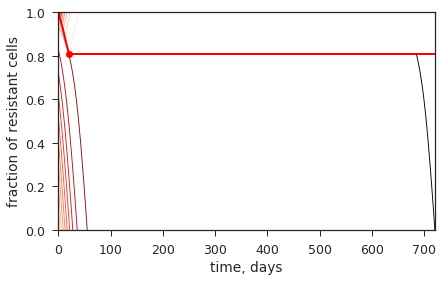

In [53]:
tmx = 720.
end_switching_curve = {'t': 24., 'x': .9/.8} 
# for Τ, Τbar in zip([28]*5,[14,21,28,35,60]):
for Τ, Τbar in zip([28],[60]):
    μ = 1./Τ; μbar = 1./Τbar
    print("Parameters: μ = %.5f, μbar = %.5f"%(μ,μbar))
    end_switching_curve['t'], end_switching_curve['x'] = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar)).x
    end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
    print("Ending point for the switching line: τ = %.1f days, x = %.1f%%" % (end_point[0], end_point[1]*100))
    print("Checking the solution - should give zero values: ")
    print(get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar))
    print("* Constructing the primary field")
    experiments = {
        'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(0,end_switching_curve['x']-(1e-3),10))+list(np.linspace(end_switching_curve['x']+(1e-6),1.,10)) } }
    primary_field = []
    for name, values in experiments.items():
        primary_field.append(get_primary_field(name,values,μ,μbar))
    print("* Constructing the switching curve")
    switching_curve = []
    x0s = np.linspace(end_switching_curve['x'],1,21); _y = end_switching_curve['t']
    
    for x0 in x0s:
        tme = fsolve(get_δρ_value,_y,args=(x0,μ,μbar))[0]
        if (tme>0):
            switching_curve = switching_curve+[[tme,get_state(tme,x0,μ,μbar)[0]]]
            _y = tme
    print("* Constructing the universal curve")
    universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
    print("* Finding the last characteristic")
    #time0 = time.time()
#     tuniv = fsolve(get_finalizing_point_from_universal_curve,tmx-40.,args=(tmx,end_point,μ,μbar,))[0]
    tuniv = root(get_finalizing_point_from_universal_curve,tmx-40,args=(tmx,end_point,μ,μbar)).x
    print(tuniv)
    #print("The proccess to find the last characteristic took %0.1f minutes" % ((time.time()-time0)/60.))
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    print("The last point on the universal line:")
    print(univ_point)
    last_trajectory = get_trajectory_with_σstar(univ_point,tmx,50,μ,μbar)
    print("Final state:")
    final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
    print(final_state)
    print("Fold-change in tumor size: %.2f"%(exp((b-d)*tmx-final_state[-1])))
    # Plotting
    plt.rcParams['figure.figsize'] = (6.75, 4)
    _k = 0
    for solutions in primary_field:
        for x0, entry in solutions.items():
            plt.plot(entry['τ'], entry['x'], 'k-', linewidth=.9, color=clrs[_k%palette_size])
            _k += 1
    plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=2,color="red")
    plt.plot([end_point[0]],[end_point[1]],marker='o',color="red")
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=2,color="red")
    plt.plot([x[0] for x in last_trajectory],[x[1] for x in last_trajectory],linewidth=.9,color="black")
    plt.xlim([0,tmx]); plt.ylim([0,1]);
    plt.xlabel("time, days"); plt.ylabel("fraction of resistant cells")
    plt.show()
    print()

In [50]:
# import csv
# from numpy.linalg import norm
# File = open("../figures/draft/sensitivity_mu-high_cost.csv", 'w')
# File.write("T,Tbar,mu,mubar,sw_start_x,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
# writer = csv.writer(File,lineterminator='\n')

tmx = 720.
end_switching_curve0 = {'t': 45.48, 'x': .932}
end_switching_curve_prev_t = end_switching_curve0['t']
tuniv = tmx-30.
Ts = [28]#np.arange(120,2,-2); 
Τbars = [60]#np.arange(120,2,-2); #need to change here if more
for Τ in Ts:
    μ = 1./Τ
    end_switching_curve = deepcopy(end_switching_curve0)
    for Τbar in Τbars:
        μbar = 1./Τbar
        print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
        success = False; err = 1.
        while (not success)|(norm(err)>1e-6):
            end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                                   'x': end_switching_curve['x']-0.002} 
            sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
            end_switching_curve_prev_t = end_switching_curve['t']
            end_switching_curve_prev_x = end_switching_curve['x']
            end_switching_curve['t'], end_switching_curve['x'] = sol.x 
            success = sol.success
            err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
            if (not success): 
                print("! Trying again...", sol.message)
            elif (norm(err)>1e-6):
                print("! Trying again... Convergence is not sufficient")       
        else:
            end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
            print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
            universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
            tuniv = root(get_finalizing_point_from_universal_curve,tmx-40,args=(tmx,end_point,μ,μbar)).x
            err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
            univ_point = get_state_universal(tuniv,end_point,μ,μbar)
            print(univ_point)
            print("tuniv = %.2f"%tuniv,"xuniv = %.2f%%"%(100*univ_point[1])," Checking the solution: ",err_tuniv)
            final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
            outcome = exp((b-d)*tmx-final_state[-1])
            print("Fold-change in tumor size: %.2f"%(outcome))
            output = [Τ,Τbar,μ,μbar,end_switching_curve['x'],end_point[0],end_point[1]]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
#             writer.writerow(output)
            print(output)
        if (Τbar==Τ):
            end_switching_curve0 = deepcopy(end_switching_curve) 

# File.close()

* Parameters: T = 28.0, Tbar = 60.0 (μ = 0.03571, μbar = 0.01667)
Ending point: t = 20.62, x = 93.42%  Checking the solution: (-2.4683081760560081e-13, -6.1207742879647273e-13)
[684.6419187714131, 0.80759771104366274, -0.37384245056996057, 7.2203468365241523]
tuniv = 684.64 xuniv = 80.76%  Checking the solution:  1.26294807945e-13
Fold-change in tumor size: 0.46
[28, 60, 0.03571428571428571, 0.016666666666666666, 0.93415346744426231, 20.622573077036552, 0.80759772154281551, 684.6419187714131, 0.80759771104366274, 0.459787064791612, -2.4683081760560081e-13, -6.1207742879647273e-13, 1.2629480794501546e-13]
